In [2]:
import segyio
import numpy as np
from scipy.signal import butter, filtfilt

x2offsets = lambda x_list: [x[0,:] for x in x_list]

def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    b, a = butter(poles, cutoff, 'highpass', fs=sample_rate)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def get_xyz(raws, offsets, num_sample: int):
    x = [np.array([offset]*(num_sample))/1000 for offset in offsets]
    y = [(np.array([list(range(num_sample))]*len(offset)).T/250) for offset in offsets]
    for i in range(len(y)): y[i] -= abs(x[i])/6.0
    z = [raw.T[:num_sample,:] for raw in raws]
    return x,y,z

def read_segy(filename, fix_unsigned_offset=False):
    with segyio.open(filename, ignore_geometry=True) as f:
        headers = f.header
        ntrace_ends = []

        for idx, header in enumerate(headers):
            # when shot number defined by TRACE_SEQUENCE_LINE
            if header[21]==0:
                if header[1]//10000 > len(ntrace_ends):
                    ntrace_ends.append(idx)
            # when station is defined as FieldRecord
            else:
                if header[9] > len(ntrace_ends):
                    ntrace_ends.append(idx)
        ntrace_ends.append(None)

        raws = [np.array(f.trace.raw[ntrace_ends[i]:ntrace_ends[i+1]]) for i in range(len(ntrace_ends)-1)]
        offsets = [np.array([header[37] for header in f.header[ntrace_ends[i]:ntrace_ends[i+1]]]) for i in range(len(ntrace_ends)-1)]
        if fix_unsigned_offset:
            for idx in range(len(offsets)):
                if offsets[idx][np.argmin(offsets[idx])-1] < offsets[idx][np.argmin(offsets[idx])+1]:
                    offsets[idx][:np.argmin(offsets[idx])] *= -1
                else:
                    offsets[idx][:np.argmin(offsets[idx])+1] *= -1
        return get_xyz(raws, offsets, num_sample=headers[0][115])

In [3]:
filename = 'nwp/kr0906ky0903_A2_mcs_s016-1.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
        headers = f.header

        # raws = [np.array(f.trace.raw[ntrace_ends[i]:ntrace_ends[i+1]]) for i in range(len(ntrace_ends)-1)]
        # offsets = [np.array([header[37] for header in f.header[ntrace_ends[i]:ntrace_ends[i+1]]]) for i in range(len(ntrace_ends)-1)]
        raws = np.array([f.trace.raw[i] for i in range(len(f.trace.raw))])
        offsets = np.array([header[37] for header in f.header])
        # print(f.trace.raw)
        # print(offsets)

        # if fix_unsigned_offset:
        #     for idx in range(len(offsets)):
        #         if offsets[idx][np.argmin(offsets[idx])-1] < offsets[idx][np.argmin(offsets[idx])+1]:
        #             offsets[idx][:np.argmin(offsets[idx])] *= -1
        #         else:
        #             offsets[idx][:np.argmin(offsets[idx])+1] *= -1
        # return get_xyz(raws, offsets, num_sample=headers[0][115])

In [47]:
sum(raws.flatten())/len(raws.flatten())

/var/folders/r9/85r4nw6n49777jfw93jkdl4m0000gn/T/ipykernel_1897/1157394283.py:1: RuntimeWarning: overflow encountered in scalar add
  sum(raws.flatten())/len(raws.flatten())


np.float64(15.720711420842155)

In [24]:
np.amin(raws)

np.int32(-32768)

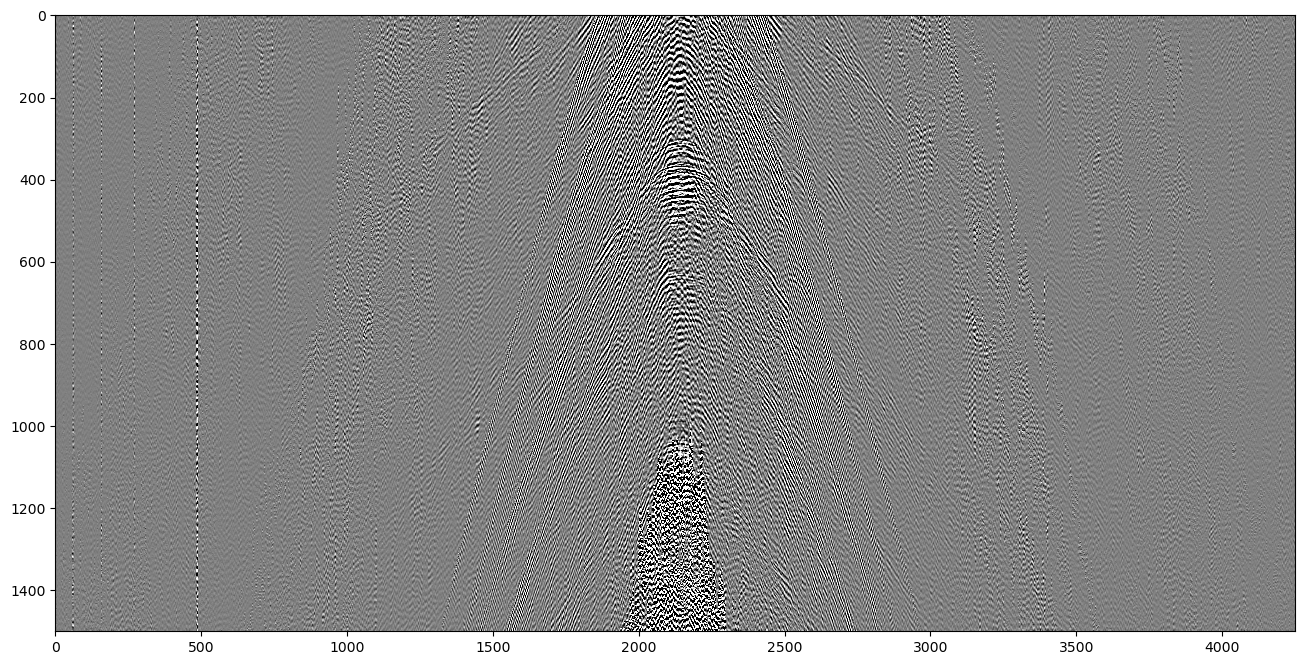

In [56]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(16,8), facecolor='w', edgecolor='k',
                       squeeze=False,
                       sharex=True)
# axs[0,0].imshow(raws.T, vmin=-300, vmax=300, cmap='grey')
axs[0,0].imshow(highpass(raws.T, 2, 250)[1500:3000,:], vmin=-300, vmax=300, cmap='grey')
axs[0,0].set_aspect('auto')

(-2000.0, 2000.0)

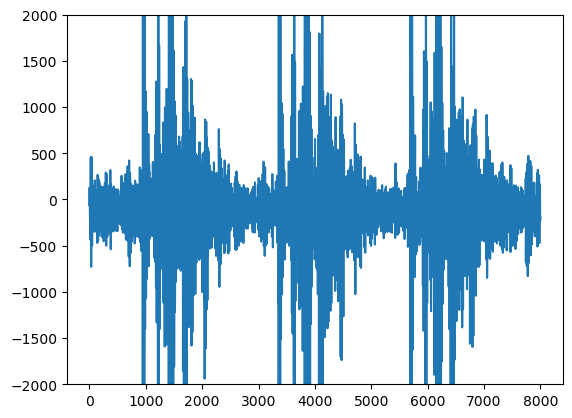

In [63]:
plt.plot(raws[1900,:])
plt.ylim(-2000,2000)